# funkSVD

In [1]:
import pandas as pd
import pyreclab
import seaborn as sns
import numpy as np
import scipy.sparse as sparse
import matplotlib.pyplot as plt

%matplotlib inline
sns.set(style="whitegrid")

In [2]:
# WARNING: ONLY RUN ONCE OR DATA WILL BE ERASED 

# Instance datasets
train_file = pd.read_csv('dataset/train.csv', sep=',', header=0)
test_file = pd.read_csv('dataset/validation.csv', sep=',', header=0)
anime_file = pd.read_csv('dataset/anime.csv', sep=',', header=0)

# Remove the registers with rating -1
train_file = train_file[train_file['rating'] != -1]
test_file = test_file[test_file['rating'] != -1]

# Remove the first row from CSV
train_file.to_csv("dataset/train.csv", index=False, header=False)
test_file.to_csv("dataset/validation.csv", index=False, header=False)
anime_file.to_csv("dataset/anime.csv", index=False, header=False)

train_file = pd.read_csv('dataset/train.csv', names = ['user_id','item_id','rating'] ,sep=',', header=0)
test_file = pd.read_csv('dataset/validation.csv', names = ['user_id','item_id','rating'], sep=',', header=0)
anime_file = pd.read_csv('dataset/anime.csv', names = ['anime_id','name','genre','type','episodes','rating','members'], sep=',', header=0)

train_file.head()

,user_id,item_id,rating
0,31006,8795,7
1,68084,14837,8
2,20881,1536,9
3,25996,1241,8
4,25409,8668,7


In [3]:
anime_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12293 entries, 0 to 12292
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12293 non-null  int64  
 1   name      12293 non-null  object 
 2   genre     12231 non-null  object 
 3   type      12268 non-null  object 
 4   episodes  12293 non-null  object 
 5   rating    12063 non-null  float64
 6   members   12293 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.4+ KB


# Functions for metrics

In [4]:
from collections import Counter

# Load anime genres
anime_genres = pd.read_csv("dataset/anime_genres.csv", index_col="anime_id")

# Popularity (used for novelty)
item_counts = Counter(train_file['item_id'])
total_count = sum(item_counts.values())
popularity = {item: count / total_count for item, count in item_counts.items()}

In [5]:
# Ground truth: the items that the user rated in the validation set
ground_truth = test_file[test_file['rating'] > 0].groupby('user_id')['item_id'].apply(set).to_dict()

def recall_at_10(recommendations, ground_truth):
    recalls = []
    for user in ground_truth:
        relevant_items = set(ground_truth[user])
        recommended_items = set(recommendations.get(user, [])[:10])
        if relevant_items:
            recalls.append(len(recommended_items & relevant_items) / len(relevant_items))
    return sum(recalls) / len(recalls)

In [6]:
def diversity(recommendations):
    scores = []
    for recs in recommendations.values():
        genres = set()
        for anime_id in recs:
            if anime_id in anime_genres.index:
                anime_genre_flags = anime_genres.loc[anime_id]
                genres.update(anime_genre_flags[anime_genre_flags == 1].index)
        scores.append(len(genres))
    return sum(scores) / len(scores)

In [7]:
def novelty(recommendations, popularity):
    scores = []
    for recs in recommendations.values():
        score = 0
        for item in recs:
            pop = popularity.get(item, 1e-10)  # avoid log(0)
            score += np.log(1 / pop)
        scores.append(score / len(recs))  # average per user
    return sum(scores) / len(scores)

# Case 1
- factors = 100
- maxiter = 50
- lr = 0.005
- lamb = 0.1

In [8]:
# definition and training of the svd object
svd = pyreclab.SVD(dataset='dataset/train.csv',
                   dlmchar=b',',
                   header=False,
                   usercol=0,
                   itemcol=1,
                   ratingcol=2,
                   factors=100) #arbitrary first factors parameter


# arbitrary first parameters :)
svd.train(maxiter=50, lr=0.005, lamb=0.1)


In [9]:
# Evaluation of the model using the validation dataset
predlist, mae, rmse = svd.test(input_file='dataset/validation.csv',
                               dlmchar=b',',
                               header=False,
                               usercol=0,
                               itemcol=1,
                               ratingcol=2)

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")


MAE: 1.0952962773987385
RMSE: 1.4204402610679057


In [10]:
# Recommendation for a arbitrary user
user_id = 25  # This can be changed
top_n = 10

recommendations = [int(item) for item in svd.recommend(str(user_id), top_n, includeRated=False)]

# Show titles of the recommended animes
anime_titles = anime_file.set_index("anime_id").loc[recommendations]["name"]
print(anime_titles)


KeyError: '[32281] not in index'

In [ ]:
recommendList, maprec, ndcg = svd.testrec(input_file='dataset/validation.csv',
                                          dlmchar=b',',
                                          header=False,
                                          usercol=0,
                                          itemcol=1,
                                          ratingcol=2,
                                          topn=10,
                                          relevance_threshold=2,
                                          includeRated=False)

# A dictionary for the top 10 recommendations
recommendations_dict = {}
validation_users = test_file['user_id'].unique()

for uid in validation_users:
    try:
        recommendations_dict[int(uid)] = [int(i) for i in svd.recommend(str(uid), 10, includeRated=False)]
    except:
        continue

recall10 = recall_at_10(recommendations_dict, ground_truth)

div_score = diversity(recommendations_dict)

novelty_score = novelty(recommendations_dict, popularity)

print(f"Recall@10: {recall10:.4f}")
print(f"MAP@10: {maprec}")
print(f"NDCG@10: {ndcg}")
print(f"Diversity: {div_score:.4f}")
print(f"Novelty: {novelty_score:.4f}")

Recall@10: 0.0128
MAP@10: 0.004845233349450085
NDCG@10: 0.0065895174144879765
Diversity: 22.5731
Novelty: 6.6509


# Case 2
- factors = 100
- maxiter = 100
- lr = 0.01
- lamb = 0.1

In [ ]:
# definition and training of the svd object
svd = pyreclab.SVD(dataset='dataset/train.csv',
                   dlmchar=b',',
                   header=False,
                   usercol=0,
                   itemcol=1,
                   ratingcol=2,
                   factors=100)

svd.train(maxiter=100, lr=0.01, lamb=0.1)


In [ ]:
# Evaluation of the model using the validation dataset
predlist, mae, rmse = svd.test(input_file='dataset/validation.csv',
                               dlmchar=b',',
                               header=False,
                               usercol=0,
                               itemcol=1,
                               ratingcol=2)

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

MAE: 1.0870365269590254
RMSE: 1.4069938703156912


In [ ]:
recommendList, maprec, ndcg = svd.testrec(input_file='dataset/validation.csv',
                                          dlmchar=b',',
                                          header=False,
                                          usercol=0,
                                          itemcol=1,
                                          ratingcol=2,
                                          topn=10,
                                          relevance_threshold=2,
                                          includeRated=False)

# A dictionary for the top 10 recommendations
recommendations_dict = {}
validation_users = test_file['user_id'].unique()

for uid in validation_users:
    try:
        recommendations_dict[int(uid)] = [int(i) for i in svd.recommend(str(uid), 10, includeRated=False)]
    except:
        continue

recall10 = recall_at_10(recommendations_dict, ground_truth)

div_score = diversity(recommendations_dict)

novelty_score = novelty(recommendations_dict, popularity)

print(f"Recall@10: {recall10:.4f}")
print(f"MAP@10: {maprec}")
print(f"NDCG@10: {ndcg}")
print(f"Diversity: {div_score:.4f}")
print(f"Novelty: {novelty_score:.4f}")

Recall@10: 0.0114
MAP@10: 0.0034233950634367056
NDCG@10: 0.00512995067594252
Diversity: 22.0771
Novelty: 7.2068


# Case 3

- factors = 200
- maxiter = 150
- lr = 0.05
- lamb = 0.1

In [ ]:
# definition and training of the svd object
svd = pyreclab.SVD(dataset='dataset/train.csv',
                   dlmchar=b',',
                   header=False,
                   usercol=0,
                   itemcol=1,
                   ratingcol=2,
                   factors=200) 

svd.train(maxiter=150, lr=0.05, lamb=0.1)

In [ ]:
# Evaluation of the model using the validation dataset
predlist, mae, rmse = svd.test(input_file='dataset/validation.csv',
                               dlmchar=b',',
                               header=False,
                               usercol=0,
                               itemcol=1,
                               ratingcol=2)

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

MAE: 1.111276084470929
RMSE: 1.4396629731530417


In [ ]:
recommendList, maprec, ndcg = svd.testrec(input_file='dataset/validation.csv',
                                          dlmchar=b',',
                                          header=False,
                                          usercol=0,
                                          itemcol=1,
                                          ratingcol=2,
                                          topn=10,
                                          relevance_threshold=2,
                                          includeRated=False)

# A dictionary for the top 10 recommendations
recommendations_dict = {}
validation_users = test_file['user_id'].unique()

for uid in validation_users:
    try:
        recommendations_dict[int(uid)] = [int(i) for i in svd.recommend(str(uid), 10, includeRated=False)]
    except:
        continue

recall10 = recall_at_10(recommendations_dict, ground_truth)

div_score = diversity(recommendations_dict)

novelty_score = novelty(recommendations_dict, popularity)

print(f"Recall@10: {recall10:.4f}")
print(f"MAP@10: {maprec}")
print(f"NDCG@10: {ndcg}")
print(f"Diversity: {div_score:.4f}")
print(f"Novelty: {novelty_score:.4f}")

Recall@10: 0.0033
MAP@10: 0.0009760663236091284
NDCG@10: 0.0014780386859204074
Diversity: 19.7760
Novelty: 8.9273


# Case 4
- factors = 200
- maxiter = 50
- lr = 0.01
- lamb = 0.1

In [ ]:
# definition and training of the svd object
svd = pyreclab.SVD(dataset='dataset/train.csv',
                   dlmchar=b',',
                   header=False,
                   usercol=0,
                   itemcol=1,
                   ratingcol=2,
                   factors=200) 

svd.train(maxiter=50, lr=0.01, lamb=0.1)

In [ ]:
# Evaluation of the model using the validation dataset
predlist, mae, rmse = svd.test(input_file='dataset/validation.csv',
                               dlmchar=b',',
                               header=False,
                               usercol=0,
                               itemcol=1,
                               ratingcol=2)

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

MAE: 1.0955465432063214
RMSE: 1.424025146072046


In [ ]:
recommendList, maprec, ndcg = svd.testrec(input_file='dataset/validation.csv',
                                          dlmchar=b',',
                                          header=False,
                                          usercol=0,
                                          itemcol=1,
                                          ratingcol=2,
                                          topn=10,
                                          relevance_threshold=2,
                                          includeRated=False)

# A dictionary for the top 10 recommendations
recommendations_dict = {}
validation_users = test_file['user_id'].unique()

for uid in validation_users:
    try:
        recommendations_dict[int(uid)] = [int(i) for i in svd.recommend(str(uid), 10, includeRated=False)]
    except:
        continue

recall10 = recall_at_10(recommendations_dict, ground_truth)

div_score = diversity(recommendations_dict)

novelty_score = novelty(recommendations_dict, popularity)

print(f"Recall@10: {recall10:.4f}")
print(f"MAP@10: {maprec}")
print(f"NDCG@10: {ndcg}")
print(f"Diversity: {div_score:.4f}")
print(f"Novelty: {novelty_score:.4f}")

Recall@10: 0.0111
MAP@10: 0.004469896683516485
NDCG@10: 0.005874885776512355
Diversity: 22.3636
Novelty: 6.7560


# Best case: Case 1 

## Parameters

- factors = 100
- maxiter = 50
- lr = 0.005
- lamb = 0.1

# Graphs

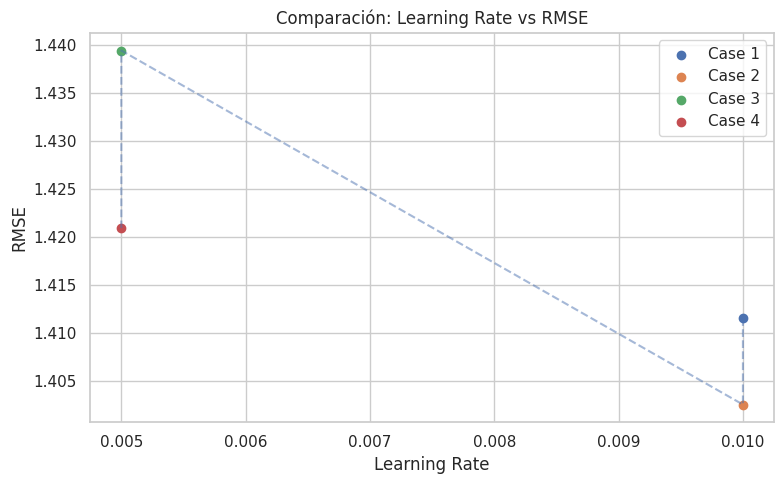

In [ ]:
# Results 

learning_rates_plot = [0.01, 0.01, 0.005, 0.005]
rmse_plot = [1.4115, 1.4025, 1.4394, 1.4209]
labels = ['Case 1', 'Case 2', 'Case 3', 'Case 4']

# Plot
plt.figure(figsize=(8, 5))
for i in range(len(labels)):
    plt.scatter(learning_rates_plot[i], rmse_plot[i], label=labels[i])

plt.plot(learning_rates_plot, rmse_plot, linestyle='--', alpha=0.5)

plt.title('Comparación: Learning Rate vs RMSE')
plt.xlabel('Learning Rate')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


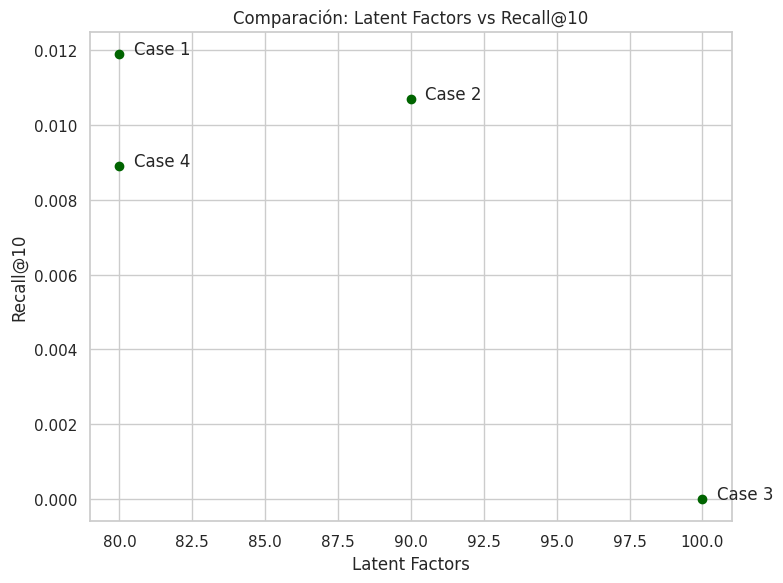

In [ ]:
# Results 
latent_factors_2d = [80, 90, 100, 80]
recall_values_2d = [0.0119, 0.0107, 0.0000, 0.0089]
labels = ["Case 1", "Case 2", "Case 3", "Case 4"]

# Plot the 2D graph
plt.figure(figsize=(8, 6))
plt.scatter(latent_factors_2d, recall_values_2d, c='darkgreen')

# Labels to the dots
for i, label in enumerate(labels):
    plt.text(latent_factors_2d[i] + 0.5, recall_values_2d[i], label)

plt.title("Comparación: Latent Factors vs Recall@10")
plt.xlabel("Latent Factors")
plt.ylabel("Recall@10")
plt.grid(True)
plt.tight_layout()
plt.show()
